# 2D case - Figure 15
Two-parameter 2D problem - Investigation of  the  convergence  of  the  reduced-order model and of the evolution of the size of the reduced-order basis.

## Libraries import  

In [1]:

import sys  
import torch
import torch.nn as nn
from neurom.HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
import neurom.src.Pre_processing as pre
from neurom.src.PDE_Library import Strain, Stress,VonMises_plain_strain
from neurom.src.Training import Training_NeuROM_multi_level
import neurom.Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
from importlib import reload  
import tomllib
import numpy as np
import argparse

torch.manual_seed(0)

/Users/daby/Documents/Code/neurom/neurom/src/Pre_processing.py:53: SyntaxWarning: invalid escape sequence '\ '
  print(" \


* WARNING: could not load tikzplotlib


## Load the config file

In [2]:
    Configuration_file = 'Configurations/config_2D_ROM.toml'

    with open(Configuration_file, mode="rb") as file:
        config = tomllib.load(file)

## Definition of the space domain and mechanical proprieties of the structure

The initial Material parameters, the geometry, mesh and the boundary conditions are set. 

In [3]:

# Material parameters definition

Mat = pre.Material(             flag_lame = False,                                  # If True should input lmbda and mu instead of E and nu
                                coef1     = config["material"]["E"],                # Young Modulus
                                coef2     = config["material"]["nu"]                # Poisson's ratio
                )

MaxElemSize2D = config["interpolation"]["MaxElemSize2D"] = 0.125
# Create mesh object
MaxElemSize = pre.ElementSize(
                                dimension     = config["interpolation"]["dimension"],
                                L             = config["geometry"]["L"],
                                order         = config["interpolation"]["order"],
                                np            = config["interpolation"]["np"],
                                MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                            )
Excluded = []
Mesh_object = pre.Mesh( 
                                config["geometry"]["Name"],                         # Create the mesh object
                                MaxElemSize, 
                                config["interpolation"]["order"], 
                                config["interpolation"]["dimension"]
                        )

Mesh_object.AddBorders(config["Borders"]["Borders"])
Mesh_object.AddBCs(                                                                 # Include Boundary physical domains infos (BCs+volume)
                                config["geometry"]["Volume_element"],
                                Excluded,
                                config["DirichletDictionryList"]
                    )                   

Mesh_object.MeshGeo()                                                               # Mesh the .geo file if .msh does not exist
Mesh_object.ReadMesh()       
Mesh_object.ExportMeshVtk()

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  3.1.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Dofs:           14230



## Parametric study definition

The hypercube describing the parametric domain used for the tensor decomposition is set-up here

In [4]:
ParameterHypercube = torch.tensor([ [   config["parameters"]["para_1_min"],
                                        config["parameters"]["para_1_max"],
                                        config["parameters"]["N_para_1"]],
                                    [   config["parameters"]["para_2_min"],
                                        config["parameters"]["para_2_max"],
                                        config["parameters"]["N_para_2"]]])

## Initialisation of the surrogate model

In [20]:
ROM_model = NeuROM(                                                                 # Build the surrogate (reduced-order) model
                    Mesh_object, 
                    ParameterHypercube, 
                    config,
                    config["solver"]["n_modes_ini"],
                    config["solver"]["n_modes_max"]
                    )

## Training the model

In [21]:
# ROM_model.Freeze_Mesh()                                                             # Set space mesh coordinates as untrainable
# ROM_model.Freeze_MeshPara()                                                         # Set parameters mesh coordinates as untrainable

# ROM_model.TrainingParameters(   
#                                 loss_decrease_c = config["training"]["loss_decrease_c"], 
#                                 Max_epochs = config["training"]["n_epochs"], 
#                                 learning_rate = config["training"]["learning_rate"]
#                             )

# ROM_model.train()                                                                   # Put the model in training mode
# ROM_model, Mesh_object = Training_NeuROM_multi_level(ROM_model,config, Mat)         

ROM_model.load_state_dict(torch.load('Pretrained_models/2D_ROM'))

<All keys matched successfully>

## Error computed at the center of the elements

Compute the error of the displacement with regard to the reference solution. Error evaluated at the center of each element

In [22]:

eval_coord_file = "GroundTruth/eval_coordinates.npy"
num_displ_file = "GroundTruth/num_displacement_E=0.0038_theta=1.57.npy"

eval_coord =  torch.tensor(np.load(eval_coord_file), dtype=torch.float64, requires_grad=False)


E_vect = [0.0038, 0.0038, 0.00314, 0.00409, 0.00409, 0.00462, 0.00501, 0.00675]
theta_vect = [1.57, 4.21, 0, 3.7, 3.13, 0.82, 2.26, 5.45]
error_vect = []
for i in range(len(E_vect)):

    num_displ_file = "GroundTruth/num_displacement_E="+str(E_vect[i])+"_theta="+str(theta_vect[i])+".npy"


    eval_coord =  torch.tensor(np.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
    num_displ = torch.tensor(np.load(num_displ_file))

    theta = torch.tensor([theta_vect[i]],dtype=torch.float64)
    theta = theta[:,None] 

    E = torch.tensor([E_vect[i]],dtype=torch.float64)
    E = E[:,None] 


    Para_coord_list = nn.ParameterList((E,theta))
    ROM_model.eval()                                                        # Put model in evaluation mode
    u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model

    u_sol_x = u_sol[0,:,0,0]
    u_sol_y = u_sol[1,:,0,0]

    u_ref_x = num_displ[:,0]
    u_ref_y = num_displ[:,1]

    u_ref_tot = torch.hstack((u_ref_x,u_ref_y))
    u_sol_tot = torch.hstack((u_sol_x,u_sol_y))

    error_u_tot = (torch.linalg.vector_norm(u_sol_tot - u_ref_tot)/torch.linalg.vector_norm(u_ref_tot)).item()
    error_vect.append(error_u_tot)

In [23]:
error_vect

[0.0011184332123288108,
 0.0008719632768102736,
 0.001491871081905327,
 0.008614273590530797,
 0.009317857702830355,
 0.002720020891251984,
 0.005347043148473478,
 0.0012342561499214977]

## Error computed at the nodes

Compute the error of the displacement with regard to the reference solution. Error evaluated at the nodes

In [9]:
eval_coord_file = "GroundTruth/nodal_coordinates.npy"

E_vect = [0.0038, 0.0038, 0.00314, 0.00409, 0.00409, 0.00462, 0.00501, 0.00675]
theta_vect = [1.57, 4.21, 0, 3.7, 3.13, 0.82, 2.26, 5.45]
error_vect = []
for i in range(len(E_vect)):

    num_displ_file = "GroundTruth/nodal_num_displacement_E="+str(E_vect[i])+"_theta="+str(theta_vect[i])+".npy"


    eval_coord =  torch.tensor(np.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
    num_displ = torch.tensor(np.load(num_displ_file))

    theta = torch.tensor([theta_vect[i]],dtype=torch.float64)
    theta = theta[:,None] 

    E = torch.tensor([E_vect[i]],dtype=torch.float64)
    E = E[:,None] 


    Para_coord_list = nn.ParameterList((E,theta))
    ROM_model.eval()                                                        # Put model in evaluation mode
    u_sol = ROM_model(eval_coord,Para_coord_list)                           # Evaluate model

    u_sol_x = u_sol[0,:,0,0]
    u_sol_y = u_sol[1,:,0,0]

    u_ref_x = num_displ[:,0]
    u_ref_y = num_displ[:,1]

    u_ref_tot = torch.hstack((u_ref_x,u_ref_y))
    u_sol_tot = torch.hstack((u_sol_x,u_sol_y))

    error_u_tot = (torch.linalg.vector_norm(u_sol_tot - u_ref_tot)/torch.linalg.vector_norm(u_ref_tot)).item()
    error_vect.append(error_u_tot)

In [11]:
error_vect

[0.0015019192422356495,
 0.1386811088647139,
 0.9999938646607428,
 0.3811123278201634,
 0.9982928590613441,
 0.2324591390869355,
 0.20730163304848198,
 0.22740738662443646]

<>:3: SyntaxWarning: invalid escape sequence '\%'
<>:3: SyntaxWarning: invalid escape sequence '\%'
/var/folders/vt/tk0pvn6x7dj443pvlvkxzcj00000gn/T/ipykernel_20428/822984578.py:3: SyntaxWarning: invalid escape sequence '\%'
  plt.ylabel('L2 error [\%]')


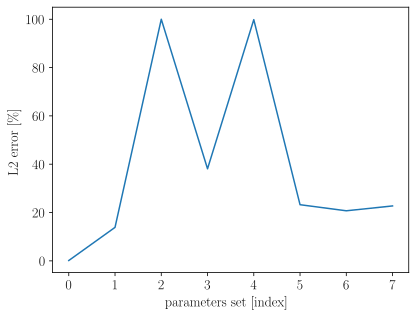

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
plt.plot([100*e for e in error_vect])
plt.ylabel('L2 error [\%]')
plt.xlabel('parameters set [index]')
plt.show()
plt.clf()

In [25]:
torch.save(ROM_model.state_dict(), 'Pretrained_models/2D_ROM')

In [14]:
ROM_model.state_dict()

OrderedDict([('float_config', tensor([0.])),
             ('Space_modes.0.float_config', tensor([0.])),
             ('Space_modes.0.coordinates_all',
              tensor([[ 0.0000,  0.0000],
                      [10.0000,  0.0000],
                      [10.0000, 10.0000],
                      ...,
                      [ 3.4497,  5.9916],
                      [ 3.4290,  3.1454],
                      [ 3.3550,  4.1050]])),
             ('Space_modes.0.values',
              tensor([[0.0000, 0.0000],
                      [0.0000, 0.0000],
                      [0.0000, 0.0000],
                      ...,
                      [0.5000, 0.5000],
                      [0.5000, 0.5000],
                      [0.5000, 0.5000]])),
             ('Space_modes.0.coordinates.free',
              tensor([[3.5035, 2.9538],
                      [9.8981, 5.0596],
                      [5.2037, 5.7337],
                      ...,
                      [3.4497, 5.9916],
                      [3